# 5.3. Flow Classification Visualization

We use **CTU-13 dataset, malware capture 43**. This notebook visualizes the final models.

The cross validated results of the best models for packet and hosts classification can be found in this notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from global_helper import *
from helper import *
from itertools import product

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

## Load data

In [3]:
# Read file and preprocess columns (takes ~1.5min)
# Only loads the traffic associated with the provided IP address.
df = load_data("../data/capture20110811.pcap.netflow.labeled")

In [4]:
df.head(5)

,duration,protocol,flags,tos,packets,bytes,flows,label,src_ip,src_port,dest_ip,dest_port
2011-08-11 10:10:00.003,0.967,UDP,INT,0,2,135,1,Background,89.31.8.11,23929,147.32.84.229,13363
2011-08-11 10:10:00.003,0.967,UDP,INT,0,2,276,1,Background,147.32.84.229,13363,89.31.8.11,23929
2011-08-11 10:10:00.006,0.000,UDP,INT,0,1,62,1,Background,208.88.186.6,34042,147.32.84.229,13363
2011-08-11 10:10:00.008,0.000,UDP,INT,0,1,78,1,Background,92.118.218.77,55246,147.32.84.229,13363
2011-08-11 10:10:00.009,0.000,UDP,INT,0,1,72,1,Background,182.185.139.181,10223,147.32.84.229,13363


## Visualize classifier performance

### Packet level

In [5]:
X_packets, y_packets = preprocess_df_packets(df, False)

C:\Users\CodeSupply\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\CodeSupply\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


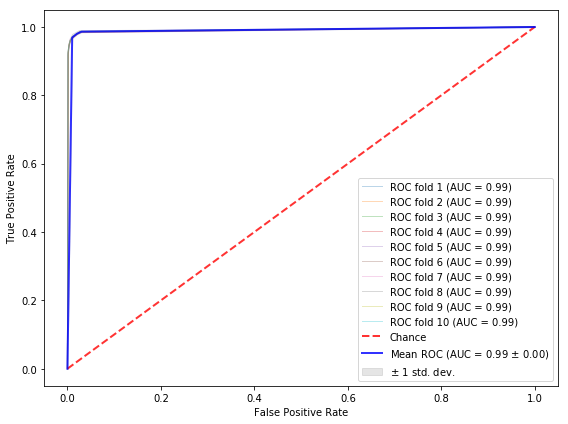

In [97]:
p_confmat, p_precision, p_recall, p_f1, p_mean_auc, p_std_auc = roc_cross_val(X_packets, y_packets, KNeighborsClassifier(5), save_path="output_figures/flowclf_roc_packets.pdf")

In [98]:
print("Precision: %.3f\nRecall:    %.3f\nF1-Score:  %.3f\nAUC:       %.3f +/- %.3f" % (p_precision, p_recall, p_f1, p_mean_auc, p_std_auc))

Precision: 0.974
Recall:    0.961
F1-Score:  0.968
AUC:       0.988 +/- 0.001


In [99]:
p_confmat[["Botnet", "Legitimate", "Total"]]

,Botnet,Legitimate,Total
Botnet,52310,2123,54433
Legitimate,1379,223957,225336
Total,53689,226080,279769


### AdaBoost alternative for comparison
k-NN is very slow on the large dataset, so AdaBoost here for comparison.

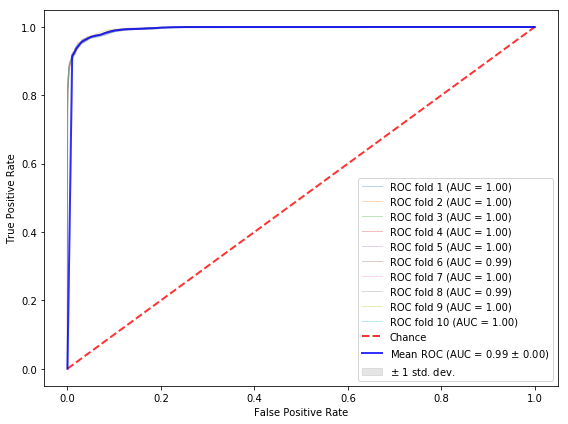

In [6]:
p_confmat_adab, p_precision_adab, p_recall_adab, p_f1_adab, p_mean_auc_adab, p_std_auc_adab, test_indices, pred_labels = roc_cross_val(X_packets, y_packets, AdaBoostClassifier(), save_path="output_figures/flowclf_roc_packets_adaboost.pdf", return_test_labels=True)

In [67]:
# For this classifier: map k-fold predictions back to original df and calculate metrics
hosts = df[df.label != "Background"][['src_ip', 'label']].copy()
hosts['label'] = hosts['label'].map({"LEGITIMATE":0, "Botnet":1})
hosts['pred_label'] = 0
hosts.reset_index(inplace=True)
hosts.drop(columns=['index'], inplace=True)

In [80]:
k = 0

splits = None
labels = None

for split,lbl in zip(test_indices, pred_labels):
    
    if splits is None:
        splits = split
        labels = lbl
    else:
        splits = np.append(splits, split)
        labels = np.append(labels, lbl)

pred_series = pd.Series(labels, index=splits).sort_index()
    
hosts['pred_label'] = pred_series

In [81]:
from sklearn.metrics import confusion_matrix

# Group by src_ip
hosts_grp = hosts.groupby(by='src_ip').max()

confusion_matrix(hosts_grp['label'], hosts_grp['pred_label'])

array([[244,  66],
       [114, 152]], dtype=int64)

In [82]:
print("Precision: %.3f\nRecall:    %.3f\nF1-Score:  %.3f\nAUC:       %.3f +/- %.3f" % (p_precision_adab, p_recall_adab, p_f1_adab, p_mean_auc_adab, p_std_auc_adab))

Precision: 0.962
Recall:    0.908
F1-Score:  0.934
AUC:       0.991 +/- 0.000


In [35]:
p_confmat_adab[["Botnet", "Legitimate", "Total"]]

,Botnet,Legitimate,Total
Botnet,49417,5016,54433
Legitimate,1971,223365,225336
Total,51388,228381,279769


## Visualize hosts classifier performance

In [5]:
X_hosts, y_hosts = preprocess_df_hosts(df, False)

C:\Users\CodeSupply\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\CodeSupply\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


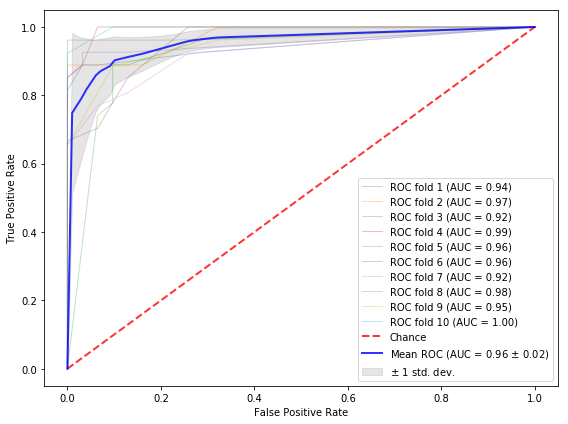

In [94]:
h_confmat, h_precision, h_recall, h_f1, h_mean_auc, h_std_auc = roc_cross_val(X_hosts, y_hosts, KNeighborsClassifier(5), save_path="output_figures/flowclf_roc_hosts.pdf")

In [95]:
print("Precision: %.3f\nRecall:    %.3f\nF1-Score:  %.3f\nAUC:       %.3f +/- %.3f" % (h_precision, h_recall, h_f1, h_mean_auc, h_std_auc))

Precision: 0.944
Recall:    0.880
F1-Score:  0.911
AUC:       0.955 +/- 0.025


In [96]:
h_confmat[["Botnet", "Legitimate", "Total"]]

,Botnet,Legitimate,Total
Botnet,234,32,266
Legitimate,14,296,310
Total,248,328,576
